In [386]:
from distutils.command import config

def random_search(problem, function_evaluations=10, **kwargs):

    history = []
    configs = []

    RANGES = GET_RANGES(problem) 

    for j in range(function_evaluations):
        config={}
        
        for i in RANGES:
            # If there is a condition, check if it holds.
            # If not, skip this hyperparameter
            if(condition(RANGES, config, i)):
                config[i] = math.nan
                continue
            
            a = RANGES[i]['range'][0] 
            b = RANGES[i]['range'][1] 
            
            # If uniform
            if(RANGES[i]['sample']==0):
                if (RANGES[i]["type"] == 0):
                    value=np.random.choice(RANGES[i]['range']) 
                    config[i]=value  
                elif (RANGES[i]["type"] == 1):
                    value=np.random.uniform(a, b) 
                    config[i]=value
                else:
                    value=np.random.randint(a, b+1) 
                    config[i]=value
            # Else log        
            else:
                value=np.random.uniform(np.log(a), np.log(b)) 
                value = np.exp(value)
                if RANGES[i]['type'] == 2:
                    value = round(value)
                config[i]=value # exponentiate value back 
      
        configs.append(config)
        history.append(GET_CONFIG_PERFORMANCE(config, problem))

    return history, configs

# Function for checking if hyperparameter has a condition and whether it holds
def condition(ranges, config, i):
        if('condition' in ranges[i]):
            if (ranges[i]['condition'](config) == False):
                return True

In [419]:
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType,normal_dist # make sure to make use of ParamType and SampleType in your code
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm
import math
from collections import Counter


# Check if current hyperparameter is active, specifically for nlayers
def condition_check(x_star, i): 
    if 'nlayers' in x_star.keys():
        layers = x_star['nlayers']
        if i[-1].isdigit():
            if int(i[-1]) > layers:
                return True

# n = number of candidate samples
def tpe2(problem, function_evaluations=150, random_warmup=10, gamma=0.5, n=10, **kwargs):

    RANGES = GET_RANGES(problem) 
    
    # Initial warm-up using random search
    loss,configs=random_search(problem,random_warmup)    
    
    hyperparameters = to_df(configs, loss)    
        
    for k in range(function_evaluations):
        
        good_df, bad_df = good_bad(gamma, hyperparameters)
        # Initialize best found configuration
        x_star = {}
        
        # Iterate through each hyperparameter
        for i in good_df.columns.difference(['loss']): 
            # Seperate into good and bad samples
            x = good_df[i].dropna().values.tolist()
            y = bad_df[i].dropna().values.tolist()
            # Add back together for sampling
            full = x + y
            # Define truncation boundaries
            a = RANGES[i]['range'][0]
            b = RANGES[i]['range'][1]
            # Check if current hyperparamter is active    
            if(condition_check(x_star, i)):
                x_star[i] = math.nan
                continue
            
            # If categorical
            if RANGES[i]['type'] == 0:
                samples = sample_uniform(RANGES[i], n)
                # Calculate probability density of the samples
                lx = categorical_pdf(x, samples)
                gx = categorical_pdf(y, samples)
                EI = calculate_EI(lx, gx)
                EI_max = np.argmax(EI)
                value = samples[EI_max]
                x_star[i] = value
                
            else:
                # If sample type is log-unfirom
                if RANGES[i]['sample'] == 1:
                    x = np.log(x)
                    y = np.log(y)
                    full = np.log(full)
                    a, b = np.log(a), np.log(b)
                    
                # Sort because we need the standard deviation to the furthest neighbour
                x.sort()                  
                y.sort()
                full.sort()
                # Calculate sigma for getting the density from the Gaussians
                std_full = scales(full, a, b)
                # Sample from truncated gaussians
                samples = sample_truncnorm(a, b, full, std_full, n)
                # In case l(x) or g(x) does not contain samples: the sigma is 0
                max_sd, max_sd_y = 0, 0
                if len(x) > 0:
                    max_sd = scales(x, a, b)
                if len(y) > 0:
                    max_sd_y = scales(y, a, b)
                # Calculate EI
                EI = get_EI(samples, x, y, a, b, max_sd, max_sd_y)
                EI_max = np.argmax(EI)
                value = samples[EI_max]
                # If sample type is log-uniform, exponentiate
                if RANGES[i]['sample'] == 1:
                    value = np.exp(value)
                # If hp type is int, round
                if RANGES[i]['type'] == 2:
                    value = round(value)      
                x_star[i] = value
        # Calculate loss and append to observations
        x_star['loss'] = GET_CONFIG_PERFORMANCE(x_star, problem) 
        hyperparameters = hyperparameters.append(x_star, ignore_index=True)            
    # Seperate all found hyperparameters for plotting EI, l(x) and g(x)
    x_final, y_final = good_bad(gamma, hyperparameters)
    EI_plot1 = plot_pdf(x_final.iloc[:,0].values,y_final.iloc[:,0].values, a, b)
    EI_plot2 = plot_pdf(x_final.iloc[:,1].values, y_final.iloc[:,1].values, a, b)
    
    best_hp = hyperparameters.iloc[hyperparameters['loss'].idxmin()]
    return hyperparameters, best_hp, x_final, y_final, EI_plot1, EI_plot2

# 
def plot_pdf(x, y, a, b):
    space = np.linspace(a, b, 100)
    g_x = pdf_array(y, a, b)
    g_x[g_x == 0] = 1
    plot = pdf_array(x, a, b) / g_x
    return plot

def pdf_array(x, a, b):
    scales_ = []
    space = np.linspace(a, b, 100)
    scales_ = scales(x, a, b)
    array = np.zeros_like(space)
    for i in range(len(x)):
        dist = truncnorm(a, b,loc=x[i], scale=scales_[i])
        array += dist.pdf(space)
    return array

    
def get_EI(samples, x, y, a, b, max_sd, max_sd_y):
    EI = []
    for j in range(len(samples)):   
        lx = 1
        gx = 1
        if len(x) > 0 and gx > 0:
            lx = get_pdf(samples[j], x, a, b, max_sd)     

        if len(y) > 0:
            gx = get_pdf(samples[j], y, a, b, max_sd_y)
        
        if gx > 0:
            EI.append(lx/gx)
        else:
            EI.append(lx)
    return EI

def return_node_list(x):
    nodes= []
    for i in x.keys():
        if 'nodes_in_layer' in i:
            nodes.append(x[i])
    return nodes
        
def to_df(configs, loss):

    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss
    
    hyper_parameters_1 = (hyper_parameters["configs"].apply(pd.Series))
    hyper_parameters_1['loss'] = hyper_parameters["loss"]
    
    
    return hyper_parameters_1
            
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, hyper_parameters):

    sorted_df=(hyper_parameters.sort_values(by=["loss"])).reset_index(drop=True)
    
    index_value=int(gamma*(sorted_df.shape[0]))
    
    good_df = sorted_df.iloc[:index_value]
    bad_df = sorted_df.iloc[index_value:sorted_df.shape[0]]
            
    return good_df, bad_df

def sample_truncnorm(a, b, x, sd, n):
    index = np.random.choice(range(len(x)))
    a, b = (a - x[index]) / sd[index], (b - x[index]) / sd[index]
    samples = stats.truncnorm.rvs(a, b, loc=x[index], scale=sd[index], size=n)
    return samples

def get_pdf(x_i, x, a, b, sd):
    n = len(x)
    total = 0
    
    for i in range(n):
        mean = x[i]
        sigma = sd[i]
        a, b = (a - mean) / sigma, (b - mean) / sigma
        total += stats.truncnorm.pdf(x_i, a, b, loc=mean, scale=sigma)
       # if error == 'error':
       #     print(x_i, a, b, mean, sigma)
        
    return total/n

def scales(x, a, b):
    if len(x) > 1:
        diff = np.diff(x)
    else:
        diff = [0]
    epsilon = (b-a)/min(100,len(x)+2)
    scales = []
    for i in range(0, len(diff)):
        max_ = max(diff[i-1], diff[i], epsilon)
        sigma = min(max_, b-a)
        scales.append(sigma)        
    scales.insert(0,min(max(diff[0], epsilon), b-a))
    scales.insert(-1,min(max(diff[-1], epsilon), b-a))
    
    return scales

def sample_uniform(hyperparameter, n):
    sample = np.random.choice(hyperparameter['range'], n)    
    return sample

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def categorical_pdf(x, samples):
    n = len(samples)
    c = Counter(x)
    densities = np.zeros(n)
    for i in range(n):
        densities[i] = c[samples[i]]
        
    return densities

def calculate_EI(lx, gx):
    gx[gx < 0.0001] = 0.0001
    EI = lx/gx
    return EI


In [ ]:
a, b, c, d, e, f = tpe2('good_range', function_evaluations = 120)

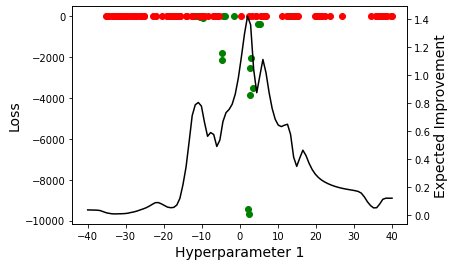

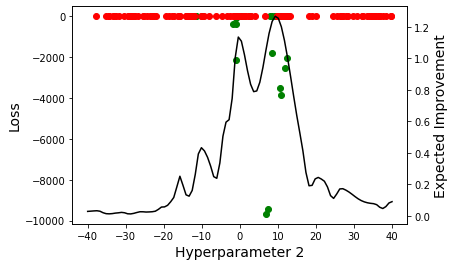

In [421]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df, bp, x, y, EI_plot1, EI_plot2= tpe2("interactive", function_evaluations = 120, random_warmup = 30, gamma =0.2)

a, b = -40, 40
space = np.linspace(a, b, 100)

fig,ax = plt.subplots()
ax.scatter(x["hyper1"],x["loss"],color="green",marker="o")
ax.set_xlabel("Hyperparameter 1", fontsize = 14)
ax.set_ylabel("Loss",color="black",fontsize=14)

ax.scatter(y["hyper1"],y["loss"],color="red",marker="o")

ax2=ax.twinx()
ax2.plot(space, EI_plot1,color="black")
ax2.set_ylabel("Expected Improvement",color="black",fontsize=14)
plt.show()

fig,ax = plt.subplots()
ax.scatter(x["hyper2"],x["loss"],color="green",marker="o")
ax.set_xlabel("Hyperparameter 2", fontsize = 14)
ax.set_ylabel("Loss",color="black",fontsize=14)

ax.scatter(y["hyper2"],y["loss"],color="red",marker="o")

ax2=ax.twinx()
ax2.plot(space, EI_plot2,color="black")
ax2.set_ylabel("Expected Improvement",color="black",fontsize=14)
plt.show()

C:\Users\evani\AppData\Local\Temp/ipykernel_6344/587042693.py:105: RuntimeWarning: overflow encountered in double_scalars
  EI.append(lx/gx)


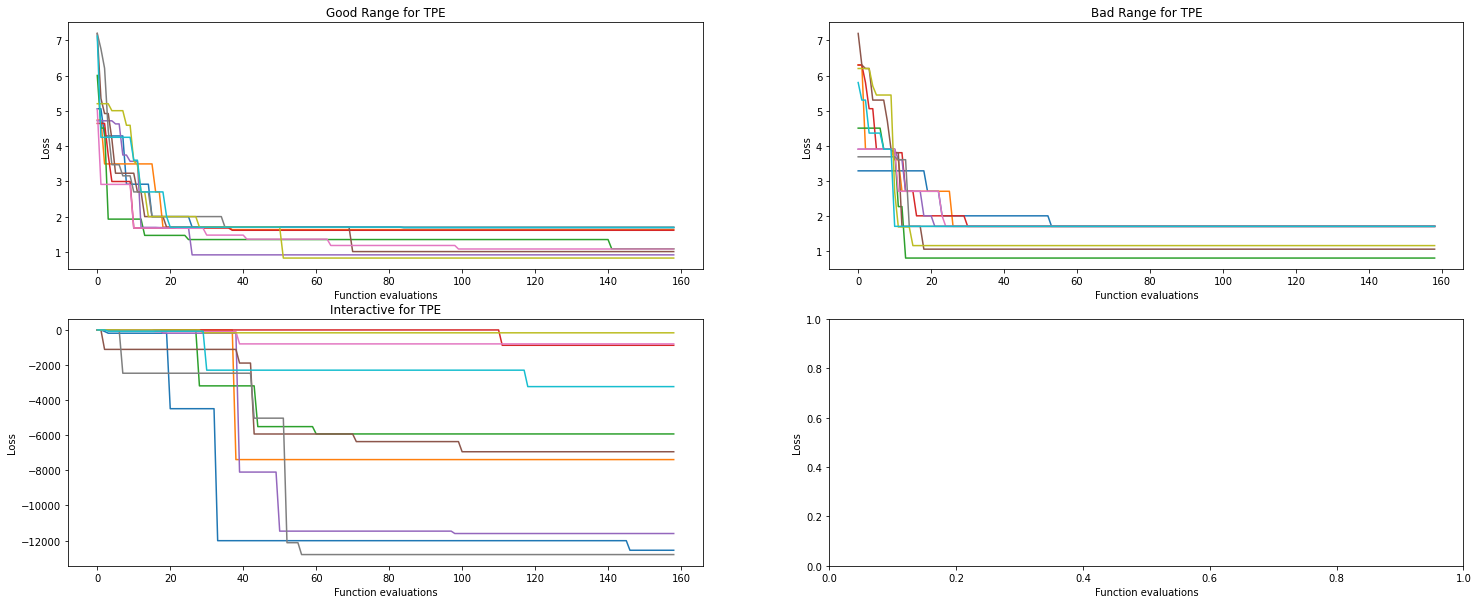

In [32]:
trails = 10

fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(25,10))

for j in range(trails):
    df = tpe2('good_range', n=24)
    losses = df['loss'].values.tolist()
    loss = []
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[0][0].plot(range(len(losses)-1),loss)   
    axs[0][0].title.set_text("Good Range for TPE")
    
for j in range(trails):
    df = tpe2('bad_range',  n=24)
    losses = df['loss'].values.tolist()
    loss = []
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[0][1].plot(range(len(losses)-1),loss) 
    axs[0][1].title.set_text("Bad Range for TPE")
    
for j in range(trails):
    df = tpe2('interactive', n=24)
    losses = df['loss'].values.tolist()
    loss = []
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[1][0].plot(range(len(losses)-1),loss) 
    axs[1][0].title.set_text("Interactive for TPE")
    
for ax in axs.flat:
    ax.set(xlabel='Function evaluations', ylabel='Loss')
plt.show()